In [1]:
import numpy as np
import pandas as pd
import ml_collections
import tensorflow as tf
from tqdm.notebook import tqdm

import os
import shutil
import importlib
from typing import Callable, Optional

from models import vanilla
from utils import plotting
from metrics import compute_segmentation_metrics
from utils.datasets.foscal.patient import FOSCALPatient
from utils.config import get_path_of_directory_with_id, load_yaml_config
from utils.preprocessing.numpy import binarize_array
from utils.preprocessing.tensorflow import resize_data, resize_mask

# Helpers

In [2]:
def import_method_from_config(
    config: ml_collections.ConfigDict, attr: str
) -> Optional[Callable]:
    """Imports a method from a config attribute."""
    if attr in config:
        return import_method(config[attr])

def import_method(method_path: str) -> Callable:
    """Import a method from a module path."""
    method_shards = method_path.split(".")
    method_shards[0] = {
        "np": "numpy",
        "tf": "tensorflow",
        "tfa": "tensorflow_addons",
    }.get(method_shards[0], method_shards[0])

    module_path = ".".join(method_shards[:-1])
    method_name = method_shards[-1]

    module = importlib.import_module(module_path)
    return getattr(module, method_name)

# Evaluation

In [3]:
def evaluate_dual_unet_on_foscal_dataset(model, config, subdir):
    
    if subdir is None:
        save_dir = config.evaluation_dir
    else:
        save_dir = os.path.join(config.evaluation_dir, subdir)


    input_shape = tuple(int(x) for x in config.model.input_shape.split(","))
    modalities = config.dataloader.modalities.split(",")

    for radiologist in ["Daniel", "Andres"]:
        
        valid_dir = os.path.join(save_dir, "test", radiologist)
        os.makedirs(valid_dir, exist_ok=True)

        metric_names = ["sens", "spec", "ppv", "npv", "dsc", "avd", "hd"]
        adc_results = {m: [] for m in metric_names}
        adc_results["patient"] = []
        dwi_results = {m: [] for m in metric_names}
        dwi_results["patient"] = []

        patient_paths = np.loadtxt(config.dataloader.test_patients_path, dtype=str)
        patient_pbar = tqdm(patient_paths)
        for patient_path in patient_paths:
            
            patient_pbar.set_description(f"{radiologist} - Processing patient {os.path.basename(patient_path)}")
            
            patient = FOSCALPatient(str(patient_path))
            original_shape = (patient.original_shape[0], patient.original_shape[1])
            patient_dir = os.path.join(valid_dir, patient.patient_id)
            os.makedirs(patient_dir, exist_ok=True)

            data_dict = patient.get_data(modalities, normalization="min_max")
            data = {
                k: np.expand_dims(v.transpose(2, 0, 1), -1) for k, v in data_dict.items()
            }
            data = np.concatenate(list(data.values()), axis=-1)
            resized_data = resize_data(data, input_shape[:2])
            resized_data = (
                resized_data[..., 0:1],
                resized_data[..., 1:],
            )

            # Predict the lesion. Keep the last output if the model is deeply supervised.
            adc_probabilities, dwi_probabilities = model.predict(resized_data)

            adc_pred_mask = binarize_array(adc_probabilities, threshold=0.5)
            adc_pred_mask = adc_pred_mask[..., 0].transpose(1, 2, 0)
            adc_resized_pred_mask = resize_mask(adc_pred_mask, original_shape).numpy()

            dwi_pred_mask = binarize_array(dwi_probabilities, threshold=0.5)
            dwi_pred_mask = dwi_pred_mask[..., 0].transpose(1, 2, 0)
            dwi_resized_pred_mask = resize_mask(dwi_pred_mask, original_shape).numpy()

            # Save each prediction and mask.
            niftis_dir = os.path.join(patient_dir, "niftis")
            os.makedirs(niftis_dir, exist_ok=True)
            shutil.copy(getattr(patient, "adc_daniel_mask_path"), niftis_dir)
            shutil.copy(getattr(patient, "dwi_daniel_mask_path"), niftis_dir)

            # Compute metrics.
            adc_mask = patient.get_mask(modalities=modalities, radiologist=radiologist)[
                "ADC"
            ]
            adc_vol_metrics = compute_segmentation_metrics(adc_mask, adc_resized_pred_mask)
            adc_results["patient"].append(patient.patient_id)
            for m in metric_names:
                adc_results[m].append(adc_vol_metrics[m])

            # Create the titles and append the arrays for creating plots later.
            title = plotting.create_title_with_metrics(**adc_vol_metrics)
            overlapped_ots_path = os.path.join(
                patient_dir, "adc_data_and_ots_overlapped.png"
            )
            animation_save_path = os.path.join(patient_dir, f"adc_animation.gif")
            plotting.plot_data_with_overlapping_ots(
                data_dict["ADC"],
                adc_mask,
                adc_resized_pred_mask,
                save_path=overlapped_ots_path,
                show_plot=False,
                title=title,
            )
            # plotting.save_animated_data_with_overlapping_ots(
            #     data_dict["ADC"],
            #     adc_mask,
            #     adc_resized_pred_mask,
            #     save_path=animation_save_path,
            #     titles=title,
            # )

            dwi_mask = patient.get_mask(modalities=modalities, radiologist=radiologist)[
                "DWI"
            ]
            dwi_vol_metrics = compute_segmentation_metrics(dwi_mask, dwi_resized_pred_mask)
            dwi_results["patient"].append(patient.patient_id)
            for m in metric_names:
                dwi_results[m].append(dwi_vol_metrics[m])

            # Create the titles and append the arrays for creating plots later.
            title = plotting.create_title_with_metrics(**dwi_vol_metrics)
            overlapped_ots_path = os.path.join(
                patient_dir, "dwi_data_and_ots_overlapped.png"
            )
            animation_save_path = os.path.join(patient_dir, f"dwi_animation.gif")
            plotting.plot_data_with_overlapping_ots(
                data_dict["DWI"],
                dwi_mask,
                dwi_resized_pred_mask,
                save_path=overlapped_ots_path,
                show_plot=False,
                title=title,
            )
            # plotting.save_animated_data_with_overlapping_ots(
            #     data_dict["DWI"],
            #     dwi_mask,
            #     dwi_resized_pred_mask,
            #     save_path=animation_save_path,
            #     titles=title,
            # )

        if len(adc_results["patient"]) != 0:
            metrics_per_patient = pd.DataFrame(adc_results)
            metrics_per_patient = metrics_per_patient.set_index("patient")
            metrics_per_patient.loc["mean"] = metrics_per_patient.mean()
            metrics_per_patient.loc["std"] = metrics_per_patient.std()
            metrics_per_patient.to_csv(os.path.join(valid_dir, "adc_patient_metrics.csv"))

        if len(dwi_results["patient"]) != 0:
            metrics_per_patient = pd.DataFrame(dwi_results)
            metrics_per_patient = metrics_per_patient.set_index("patient")
            metrics_per_patient.loc["mean"] = metrics_per_patient.mean()
            metrics_per_patient.loc["std"] = metrics_per_patient.std()
            metrics_per_patient.to_csv(os.path.join(valid_dir, "dwi_patient_metrics.csv"))

def evaluate_unet_on_foscal_dataset(model, config, subdir):
    
    if subdir is None:
        save_dir = config.evaluation_dir
    else:
        save_dir = os.path.join(config.evaluation_dir, subdir)


    input_shape = tuple(int(x) for x in config.model.input_shape.split(","))
    modalities = config.dataloader.modalities.split(",")

    for radiologist in ["Daniel", "Andres"]:
        
        valid_dir = os.path.join(save_dir, "valid", radiologist)
        os.makedirs(valid_dir, exist_ok=True)

        metric_names = ["sens", "spec", "ppv", "npv", "dsc", "avd", "hd"]
        results = {m: [] for m in metric_names}
        results["patient"] = []
        patient_paths = np.loadtxt(config.dataloader.valid_patients_path, dtype=str)
        for patient_path in patient_paths:
            patient = FOSCALPatient(str(patient_path))
            original_shape = (patient.original_shape[0], patient.original_shape[1])
            patient_dir = os.path.join(valid_dir, patient.patient_id)
            os.makedirs(patient_dir, exist_ok=True)

            data_dict = patient.get_data(modalities, normalization="min_max")
            data = {
                k: np.expand_dims(v.transpose(2, 0, 1), -1) for k, v in data_dict.items()
            }
            data = np.concatenate(list(data.values()), axis=-1)
            resized_data = resize_data(data, input_shape[:2])

            # Predict the lesion. Keep the last output if the model is deeply supervised.
            probabilities = model.predict(resized_data)
            if isinstance(probabilities, (list, tuple)):
                probabilities = probabilities[-1]
            pred_mask = binarize_array(probabilities, threshold=0.5)
            pred_mask = pred_mask[..., 0].transpose(1, 2, 0)
            resized_pred_mask = resize_mask(pred_mask, original_shape).numpy()

            # Save each prediction and mask.
            niftis_dir = os.path.join(patient_dir, "niftis")
            os.makedirs(niftis_dir, exist_ok=True)

            mask_attr = modalities[0].lower()
            if hasattr(patient, mask_attr):
                shutil.copy(getattr(patient, mask_attr + "_path"), niftis_dir)

                # Compute metrics.
                mask = patient.get_mask(modalities=modalities, radiologist=radiologist)[
                    modalities[0]
                ]
                vol_metrics = compute_segmentation_metrics(mask, resized_pred_mask)
                results["patient"].append(patient.patient_id)
                for m in metric_names:
                    results[m].append(vol_metrics[m])

                # Create the titles and append the arrays for creating plots later.
                title = plotting.create_title_with_metrics(**vol_metrics)
                key_list = list(data_dict.keys())
                first_key = key_list[0]

                overlapped_ots_path = os.path.join(
                    patient_dir, "data_and_ots_overlapped.png"
                )
                animation_save_path = os.path.join(patient_dir, f"animation.gif")

                plotting.plot_data_with_overlapping_ots(
                    data_dict[first_key],
                    mask,
                    resized_pred_mask,
                    save_path=overlapped_ots_path,
                    show_plot=False,
                    title=title,
                )

                # plotting.save_animated_data_with_overlapping_ots(
                #     data_dict[first_key],
                #     mask,
                #     resized_pred_mask,
                #     save_path=animation_save_path,
                #     titles=title,
                # )

        if len(results["patient"]) != 0:
            metrics_per_patient = pd.DataFrame(results)
            metrics_per_patient = metrics_per_patient.set_index("patient")
            metrics_per_patient.loc["mean"] = metrics_per_patient.mean()
            metrics_per_patient.loc["std"] = metrics_per_patient.std()
            metrics_per_patient.to_csv(os.path.join(valid_dir, "patient_metrics.csv"))

Create a function that deals with the execution of both type of experiments

In [4]:
def evaluate_experiment_best_model(experiment_id, is_dual=False):
    
    tf.keras.backend.clear_session()

    experiment_dir = get_path_of_directory_with_id(experiment_id)

    # Load config files.
    config = load_yaml_config(os.path.join(experiment_dir, "config", "config.yml"))
    config = ml_collections.ConfigDict(config)

    # Create the model and load the best weights.
    model_config = config.model.to_dict()
    model_config["input_shape"] = tuple(int(s) for s in config.model.input_shape.split(","))
    model_config["filters_per_level"] = [int(f) for f in config.model.filters_per_level.split(",")]
    model_config["blocks_depth"] = [int(f) for f in config.model.blocks_depth.split(",")]
    model_config["norm_layer"] = import_method_from_config(config.model, "norm_layer")
    model_config["upsample_layer"] = import_method_from_config(config.model, "upsample_layer")
    if config.model.attention_layer is not None:
        model_config["attention_layer"] = import_method_from_config(
            config.model, "attention_layer"
        )
    else:
        model_config["attention_layer"] = None
    model_config["pooling_layer"] = import_method_from_config(config.model, "pooling_layer")

    # Iterate over the test patients and compute the metrics for both radiologists.
    if is_dual:
        model = vanilla.DualUnet(**model_config)
        model.load_weights(config.best_weights_path).expect_partial()
        evaluate_dual_unet_on_foscal_dataset(model, config, "best")
    else:
        encoder = vanilla.UNetEncoder(**model_config)
        skip_names = vanilla.get_skip_names_from_encoder(encoder)
        model = vanilla.UNet(encoder, skip_names, **model_config)
        # hidden_layer_names = vanilla.get_output_names_for_deep_supervision(model)
        # model = vanilla.add_deep_supervision_to_unet(model, hidden_layer_names)
        model.load_weights(config.best_weights_path).expect_partial()
        evaluate_unet_on_foscal_dataset(model, config, "best")

In [7]:
for i in [11]:
    evaluate_experiment_best_model(i, is_dual=True)

[<KerasTensor: shape=(None, 14, 14, 1024) dtype=float32 (created by layer 'adc_unet_bottleneck_drop')>] [<KerasTensor: shape=(None, 14, 14, 1024) dtype=float32 (created by layer 'dwi_unet_bottleneck_drop')>]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Evaluate the baseline UNets

In [52]:
for experiment_id in tqdm(range(10)):
    evaluate_experiment_best_model(experiment_id, is_dual=True)

100%|██████████| 10/10 [16:43<00:00, 100.40s/it]


Evaluate the Dual UNets

In [53]:
for experiment_id in tqdm(range(10, 15)):
    evaluate_experiment_best_model(experiment_id)

100%|██████████| 5/5 [16:02<00:00, 192.54s/it]


# Predict for figures

In [5]:
import nibabel as nib

def get_nii_mask(
    modality_nifti: nib.Nifti1Image, 
    mask_nifti: nib.Nifti1Image
) -> nib.Nifti1Image:
    """Returns the union of a reference mask `mask_ref_nifti` and a complement 
    mask `mask_comp_nifti` in NifTI format. Inputs are expected to be binary."""

    return nib.Nifti1Image(
        mask_nifti,
        modality_nifti.affine, 
        modality_nifti.header
    )

def dual_predict_on_foscal_patients(model, config, patient_paths, experiment_id):
    input_shape = tuple(int(x) for x in config.model.input_shape.split(","))
    modalities = config.dataloader.modalities.split(",")
        
    for patient_path in patient_paths:
        patient_dir = os.path.join("figs", "results", f"{experiment_id}", os.path.basename(patient_path))
        os.makedirs(patient_dir, exist_ok=True)

        patient = FOSCALPatient(str(patient_path))
        original_shape = (patient.original_shape[0], patient.original_shape[1])

        data_dict = patient.get_data(modalities, normalization="min_max")
        data = {
            k: np.expand_dims(v.transpose(2, 0, 1), -1) for k, v in data_dict.items()
        }
        data = np.concatenate(list(data.values()), axis=-1)
        resized_data = resize_data(data, input_shape[:2])
        resized_data = (
            resized_data[..., 0:1],
            resized_data[..., 1:],
        )

        # Predict the lesion. Keep the last output if the model is deeply supervised.
        adc_probabilities, dwi_probabilities = model.predict(resized_data)

        adc_pred_mask = binarize_array(adc_probabilities, threshold=0.5)
        adc_pred_mask = adc_pred_mask[..., 0].transpose(1, 2, 0)
        adc_resized_pred_mask = resize_mask(adc_pred_mask, original_shape).numpy()

        dwi_pred_mask = binarize_array(dwi_probabilities, threshold=0.5)
        dwi_pred_mask = dwi_pred_mask[..., 0].transpose(1, 2, 0)
        dwi_resized_pred_mask = resize_mask(dwi_pred_mask, original_shape).numpy()

        # Get the annotations for each radiologist.
        daniel_masks = patient.get_mask(modalities=modalities, radiologist="Daniel")
        andres_masks = patient.get_mask(modalities=modalities, radiologist="Andres")
        daniel_adc_mask, daniel_dwi_mask = daniel_masks["ADC"], daniel_masks["DWI"]
        andres_adc_mask, andres_dwi_mask = andres_masks["ADC"], andres_masks["DWI"]

        # Save resources as npy.
        np.save(os.path.join(patient_dir, "adc.npy"), data[..., 0].transpose(1, 2, 0))
        np.save(os.path.join(patient_dir, "adc_daniel_mask.npy"), daniel_adc_mask)
        np.save(os.path.join(patient_dir, "adc_andres_mask.npy"), andres_adc_mask)
        np.save(os.path.join(patient_dir, "adc_resized_pred_mask.npy"), adc_resized_pred_mask)
        np.save(os.path.join(patient_dir, "dwi.npy"), data[..., 1].transpose(1, 2, 0))
        np.save(os.path.join(patient_dir, "dwi_daniel_mask.npy"), daniel_dwi_mask)
        np.save(os.path.join(patient_dir, "dwi_andres_mask.npy"), andres_dwi_mask)
        np.save(os.path.join(patient_dir, "dwi_resized_pred_mask.npy"), dwi_resized_pred_mask)

        # Save resources as nifti.
        adc_predicted_nii_mask = get_nii_mask(patient.adc_daniel_mask, adc_resized_pred_mask)
        dwi_predicted_nii_mask = get_nii_mask(patient.dwi_daniel_mask, dwi_resized_pred_mask)
        nib.save(adc_predicted_nii_mask, os.path.join(patient_dir, "adc_predicted_mask.nii.gz"))
        nib.save(dwi_predicted_nii_mask, os.path.join(patient_dir, "dwi_predicted_mask.nii.gz"))

        nib.save(patient.adc_daniel_mask, os.path.join(patient_dir, "adc_daniel_mask.nii.gz"))
        nib.save(patient.adc_andres_mask, os.path.join(patient_dir, "adc_andres_mask.nii.gz"))
        nib.save(patient.dwi_daniel_mask, os.path.join(patient_dir, "dwi_daniel_mask.nii.gz"))
        nib.save(patient.dwi_andres_mask, os.path.join(patient_dir, "dwi_andres_mask.nii.gz"))


def predict_on_foscal_patients(model, config, patient_paths, experiment_id):
    input_shape = tuple(int(x) for x in config.model.input_shape.split(","))
    modalities = config.dataloader.modalities.split(",")
    assert len(modalities) == 1
        
    for patient_path in patient_paths:
        patient_dir = os.path.join("figs", "results", f"{experiment_id}", os.path.basename(patient_path))
        os.makedirs(patient_dir, exist_ok=True)

        patient = FOSCALPatient(str(patient_path))
        original_shape = (patient.original_shape[0], patient.original_shape[1])

        data_dict = patient.get_data(modalities, normalization="min_max")
        data = {
            k: np.expand_dims(v.transpose(2, 0, 1), -1) for k, v in data_dict.items()
        }
        data = np.concatenate(list(data.values()), axis=-1)
        resized_data = resize_data(data, input_shape[:2])

        # Predict the lesion. Keep the last output if the model is deeply supervised.
        probabilities = model.predict(resized_data)
        if isinstance(probabilities, (list, tuple)):
            probabilities = probabilities[-1]
        pred_mask = binarize_array(probabilities, threshold=0.5)
        pred_mask = pred_mask[..., 0].transpose(1, 2, 0)
        resized_pred_mask = resize_mask(pred_mask, original_shape).numpy()

        # Get the annotations for each radiologist.
        modality = modalities[0]
        daniel_masks = patient.get_mask(modalities=modalities, radiologist="Daniel")
        andres_masks = patient.get_mask(modalities=modalities, radiologist="Andres")
        daniel_mask = daniel_masks[modality]
        andres_mask = andres_masks[modality]

        # Save resources as npy.
        np.save(os.path.join(patient_dir, f"{modality.lower()}.npy"), data[..., 0].transpose(1, 2, 0))
        np.save(os.path.join(patient_dir, f"{modality.lower()}_daniel_mask.npy"), daniel_mask)
        np.save(os.path.join(patient_dir, f"{modality.lower()}_andres_mask.npy"), andres_mask)
        np.save(os.path.join(patient_dir, f"{modality.lower()}_resized_pred_mask.npy"), resized_pred_mask)

        # Save resources as nifti.
        predicted_nii_mask = get_nii_mask(getattr(patient, f"{modality.lower()}_daniel_mask"), resized_pred_mask)
        nib.save(predicted_nii_mask, os.path.join(patient_dir, f"{modality.lower()}_predicted_mask.nii.gz"))
        nib.save(getattr(patient, f"{modality.lower()}_daniel_mask"), os.path.join(patient_dir, f"{modality.lower()}_daniel_mask.nii.gz"))
        nib.save(getattr(patient, f"{modality.lower()}_andres_mask"), os.path.join(patient_dir, f"{modality.lower()}_andres_mask.nii.gz"))

In [6]:
# paciente 021, 034, experimento 13 (fold 4)
def dual_predict_for_experiment(experiment_id, patient_paths, is_dual=False):
    
    tf.keras.backend.clear_session()

    experiment_dir = get_path_of_directory_with_id(experiment_id)

    # Load config files.
    config = load_yaml_config(os.path.join(experiment_dir, "config", "config.yml"))
    config = ml_collections.ConfigDict(config)

    # Create the model and load the best weights.
    model_config = config.model.to_dict()
    model_config["input_shape"] = tuple(int(s) for s in config.model.input_shape.split(","))
    model_config["filters_per_level"] = [int(f) for f in config.model.filters_per_level.split(",")]
    model_config["blocks_depth"] = [int(f) for f in config.model.blocks_depth.split(",")]
    model_config["norm_layer"] = import_method_from_config(config.model, "norm_layer")
    model_config["upsample_layer"] = import_method_from_config(config.model, "upsample_layer")
    model_config["attention_layer"] = import_method_from_config(config.model, "attention_layer")
    model_config["pooling_layer"] = import_method_from_config(config.model, "pooling_layer")

    # Iterate over the test patients and compute the metrics for both radiologists.
    if is_dual:
        model = vanilla.DualUnet(**model_config)
        model.load_weights(config.best_weights_path).expect_partial()
        dual_predict_on_foscal_patients(model, config, patient_paths, experiment_id)
    else:
        encoder = vanilla.UNetEncoder(**model_config)
        skip_names = vanilla.get_skip_names_from_encoder(encoder)
        model = vanilla.UNet(encoder, skip_names, **model_config)
        # hidden_layer_names = vanilla.get_output_names_for_deep_supervision(model)
        # model = vanilla.add_deep_supervision_to_unet(model, hidden_layer_names)
        model.load_weights(config.best_weights_path).expect_partial()
        predict_on_foscal_patients(model, config, patient_paths, experiment_id)

In [8]:
patient_paths = [
    "/data/Datasets/stroke/MICCAI/test/ACV-222", 
    "/data/Datasets/stroke/MICCAI/test/ACV-201"
]

experiment_ids = [5, 6, 7]
are_dual = [True, False, False]
for experiment_id, is_dual in tqdm(zip(experiment_ids, are_dual)):
    dual_predict_for_experiment(experiment_id, patient_paths, is_dual=is_dual)

0it [00:00, ?it/s]

In [31]:
patient = FOSCALPatient("/data/Datasets/stroke/MICCAI/test/ACV-222")
adc = patient.get_data(["ADC"], normalization="min_max")["ADC"]
dwi = patient.get_data(["ADC", "DWI"], normalization="min_max")["DWI"]

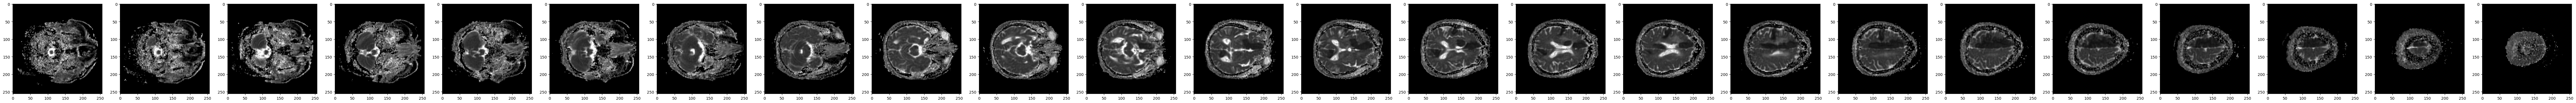

In [29]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, adc.shape[-1], figsize=(5*adc.shape[-1], 5))
for i in range(adc.shape[-1]):
    axs[i].imshow(adc[..., i], cmap="gray")
plt.savefig("adc.png")
plt.show()

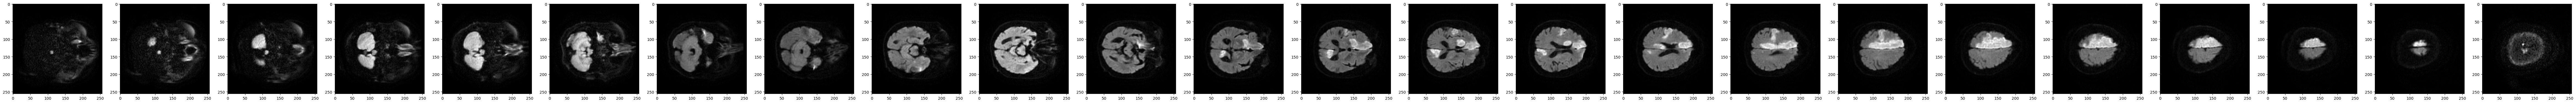

In [32]:
fig, axs = plt.subplots(1, adc.shape[-1], figsize=(5*adc.shape[-1], 5))
for i in range(adc.shape[-1]):
    axs[i].imshow(dwi[..., i], cmap="gray")
plt.savefig("dwi.png")
plt.show()

In [8]:
import nibabel as nib
import numpy as np

def get_modality_with_brain_extraction(
    modality_nifti: nib.Nifti1Image, 
    mask_nifti: nib.Nifti1Image
) -> nib.Nifti1Image:
    """Returns the union of a reference mask `mask_ref_nifti` and a complement 
    mask `mask_comp_nifti` in NifTI format. Inputs are expected to be binary."""
    final_dtype = modality_nifti.get_data_dtype()
    modality_data = modality_nifti.get_fdata().astype(final_dtype)
    mask_data = mask_nifti.get_fdata().astype(final_dtype)
    modality_with_brain_extraction = modality_data * mask_data

    return nib.Nifti1Image(
        modality_with_brain_extraction,
        modality_nifti.affine, 
        modality_nifti.header
    )

def get_modality_with_brain_extraction_2(
    modality_nifti: nib.Nifti1Image, 
    mask_nifti: nib.Nifti1Image
) -> nib.Nifti1Image:
    """Returns the union of a reference mask `mask_ref_nifti` and a complement 
    mask `mask_comp_nifti` in NifTI format. Inputs are expected to be binary."""
    final_dtype = modality_nifti.get_data_dtype()
    modality_data = modality_nifti.get_fdata().astype(final_dtype)
    mask_data = mask_nifti.get_fdata().astype(final_dtype)
    modality_with_brain_extraction = modality_data * np.repeat(mask_data[..., np.newaxis], 2, axis=-1)

    return nib.Nifti1Image(
        modality_with_brain_extraction,
        modality_nifti.affine, 
        modality_nifti.header
    )

# ACV-222.
adc_222 = nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-222/ADC_real.nii.gz")
adc_222_brain_mask = nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-222/ADC_final_brain_mask.nii.gz")
adc_222_brain_extracted = get_modality_with_brain_extraction(adc_222, adc_222_brain_mask)
nib.save(adc_222_brain_extracted, "/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-222/ADC_brain_extracted.nii.gz")

dwi_222 = nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-222/DWI_real.nii.gz")
dwi_222_brain_mask = nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-222/ADC_final_brain_mask.nii.gz")
dwi_222_brain_extracted = get_modality_with_brain_extraction_2(dwi_222, dwi_222_brain_mask)
nib.save(dwi_222_brain_extracted, "/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-222/DWI_brain_extracted.nii.gz")


# ACV-201.
adc_201 = nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/ADC_real.nii.gz")
adc_201_brain_mask = nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/ADC_final_brain_mask.nii.gz")
adc_201_brain_extracted = get_modality_with_brain_extraction(adc_201, adc_201_brain_mask)
nib.save(adc_201_brain_extracted, "/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/ADC_brain_extracted.nii.gz")

dwi_201 = nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/DWI_real.nii.gz")
dwi_201_brain_mask = nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/ADC_final_brain_mask.nii.gz")
dwi_201_brain_extracted = get_modality_with_brain_extraction_2(dwi_201, dwi_201_brain_mask)
nib.save(dwi_201_brain_extracted, "/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/DWI_brain_extracted.nii.gz")


In [ ]:
import matplotlib.pyplot as plt
from utils.preprocessing.numpy import get_idxs_of_annotated_slices, min_max_normalization
from utils.plotting import plot_data_with_overlapping_ots, overlay_masks_on_data, add_annotations_legend

RED_COLOR = (1.0, 0.0, 0.0)
GREEN_COLOR = (0.0, 1.0, 0.0)
BLUE_COLOR = (0.0, 0.0, 1.0)

def create_mask_with_contours(
     data,
     true_mask,
     pred_mask,
     true_color=RED_COLOR, 
     pred_color=BLUE_COLOR,
     true_mask_with_contours=True,
     pred_mask_with_contours=False
 ):
     if not (data.min() >= 0.0 and data.max() <= 1.0):
         data = min_max_normalization(data)
 
     # Add axis if data is a single slice.
     if data.ndim == 2:
         data = np.expand_dims(data, axis=-1)
         true_mask = np.expand_dims(true_mask, axis=-1)
         pred_mask = np.expand_dims(pred_mask, axis=-1)
 
     intersection_color = tuple(sum(x) for x in zip(true_color, pred_color))
 
     # Transpose (H, W, S) -> (S, W, H) to iterate over slices (S).
     data = data.transpose(2, 0, 1)
     true_mask = true_mask.transpose(2, 0, 1)
     pred_mask = pred_mask.transpose(2, 0, 1)
 
     # Combine the data with the OTs.
     data_w_overlayed_masks = overlay_masks_on_data(
         data,
         true_mask,
         pred_mask,
         true_mask_with_contours=true_mask_with_contours,
         pred_mask_with_contours=pred_mask_with_contours,
         true_color=true_color,
         pred_color=pred_color,
     )
 
     return data_w_overlayed_masks.clip(0.0, 1.0)

In [40]:
import nibabel as nib
patient = FOSCALPatient("/data/Datasets/stroke/MICCAI/test/ACV-201/")
data = patient.get_data(["ADC", "DWI"], normalization="min_max")
adc, dwi = data["ADC"], data["DWI"]

masks_andres = patient.get_mask(radiologist="Andres")
adc_mask_andres, dwi_mask_andres = masks_andres["ADC"], masks_andres["DWI"]

masks_daniel = patient.get_mask(radiologist="Daniel")
adc_mask_daniel, dwi_mask_daniel = masks_daniel["ADC"], masks_daniel["DWI"]

adc_pred_201_005 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/adc_predicted_mask.nii.gz").get_fdata())
dwi_pred_201_005 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/dwi_predicted_mask.nii.gz").get_fdata())


adc_pred_201_005 = adc_pred_201_005.astype(np.float32)
dwi_pred_201_005 = dwi_pred_201_005.astype(np.float32)

In [41]:
idxs = [19, 20, 21]

adc_pred_201_005 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/adc_predicted_mask.nii.gz").get_fdata())
dwi_pred_201_005 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/dwi_predicted_mask.nii.gz").get_fdata())
adc_pred_201_005 = adc_pred_201_005.astype(np.float32)
dwi_pred_201_005 = dwi_pred_201_005.astype(np.float32)

o = create_mask_with_contours(adc, adc_mask_andres, adc_pred_201_005)
for idx in idxs:
    plt.imshow(o[idx])
    plt.axis("off")
    print(compute_segmentation_metrics(adc_mask_andres[...,idx], adc_pred_201_005[...,idx])['dsc'])
    plt.savefig("figs/201_005_adc_{}.png".format(idx),bbox_inches='tight')

0.7443707701197834
0.7330129488719797
0.4742618663703744


In [45]:
adc_pred_201_006 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/6/ACV-201/adc_predicted_mask.nii.gz").get_fdata())
adc_pred_201_006 = adc_pred_201_006.astype(np.float32)

o = create_mask_with_contours(adc, adc_mask_andres, adc_pred_201_006)
for idx in idxs:
    plt.imshow(o[idx])
    plt.axis("off")
    print(compute_segmentation_metrics(adc_mask_andres[...,idx], adc_pred_201_006[...,idx])['dsc'])
    plt.savefig("figs/201_006_adc_{}.png".format(idx),bbox_inches='tight')

0.5369926439363845
0.33407084445022883
0.0


In [50]:
o = create_mask_with_contours(dwi, dwi_mask_andres, dwi_pred_201_005)
for idx in idxs:
    plt.imshow(o[idx])
    plt.axis("off")
    print(compute_segmentation_metrics(dwi_mask_andres[...,idx], dwi_pred_201_005[...,idx])['dsc'])
    plt.savefig("figs/201_005_dwi_{}.png".format(idx), bbox_inches='tight')

0.8036824870974916
0.7722622237823307
0.7701899038834801


In [49]:
dwi_pred_201_007 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/7/ACV-201/dwi_predicted_mask.nii.gz").get_fdata())
dwi_pred_201_007 = dwi_pred_201_007.astype(np.float32)
o = create_mask_with_contours(dwi, dwi_mask_andres, dwi_pred_201_007)
for idx in idxs:
    plt.imshow(o[idx])
    plt.axis("off")
    print(compute_segmentation_metrics(dwi_mask_andres[...,idx], dwi_pred_201_007[...,idx])['dsc'])
    plt.savefig("figs/201_007_dwi_{}.png".format(idx), bbox_inches='tight')

0.8684222068227472
0.8580198363653078
0.5819757791848528


# Radiologist 2

In [51]:
idxs = [19, 20, 21]

adc_pred_201_005 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/adc_predicted_mask.nii.gz").get_fdata())
dwi_pred_201_005 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/5/ACV-201/dwi_predicted_mask.nii.gz").get_fdata())
adc_pred_201_005 = adc_pred_201_005.astype(np.float32)
dwi_pred_201_005 = dwi_pred_201_005.astype(np.float32)

o = create_mask_with_contours(adc, adc_mask_daniel, adc_pred_201_005)
for idx in idxs:
    plt.imshow(o[idx])
    plt.axis("off")
    print(compute_segmentation_metrics(adc_mask_daniel[...,idx], adc_pred_201_005[...,idx])['dsc'])
    plt.savefig("figs/201_005_adc_{}_daniel.png".format(idx),bbox_inches='tight')

0.7966436880252983
0.7695584613270473
0.6904194405632722


In [52]:
adc_pred_201_006 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/6/ACV-201/adc_predicted_mask.nii.gz").get_fdata())
adc_pred_201_006 = adc_pred_201_006.astype(np.float32)

o = create_mask_with_contours(adc, adc_mask_daniel, adc_pred_201_006)
for idx in idxs:
    plt.imshow(o[idx])
    plt.axis("off")
    print(compute_segmentation_metrics(adc_mask_daniel[...,idx], adc_pred_201_006[...,idx])['dsc'])
    plt.savefig("figs/201_006_adc_{}_daniel.png".format(idx),bbox_inches='tight')

0.5557035121189229
0.27445498361949194
0.0


In [53]:
o = create_mask_with_contours(dwi, dwi_mask_daniel, dwi_pred_201_005)
for idx in idxs:
    plt.imshow(o[idx])
    plt.axis("off")
    print(compute_segmentation_metrics(dwi_mask_daniel[...,idx], dwi_pred_201_005[...,idx])['dsc'])
    plt.savefig("figs/201_005_dwi_{}_daniel.png".format(idx), bbox_inches='tight')

0.7383606521028154
0.7697812624553096
0.7788361080582353


In [54]:
dwi_pred_201_007 = min_max_normalization(nib.load("/home/sangohe/projects/isbi2023-foscal/figs/results/7/ACV-201/dwi_predicted_mask.nii.gz").get_fdata())
dwi_pred_201_007 = dwi_pred_201_007.astype(np.float32)
o = create_mask_with_contours(dwi, dwi_mask_daniel, dwi_pred_201_007)
for idx in idxs:
    plt.imshow(o[idx])
    plt.axis("off")
    print(compute_segmentation_metrics(dwi_mask_daniel[...,idx], dwi_pred_201_007[...,idx])['dsc'])
    plt.savefig("figs/201_007_dwi_{}_daniel.png".format(idx), bbox_inches='tight')

0.6792702483521442
0.6648816026702233
0.48882119068518615
